---
layout: post
title:  "A visual tutorial of Inversion Sampling"
desc: "Efficient inversion sampling explained with Python."
long_desc: "In this article, we'll explore inversion sampling in Python. Covering the concepts behind it, analytic inversion and also a generalised Python method to invert arbitrary data and functions, everything you need to get up and running is here."
date: ###DATE
categories: [tutorial]
tags: [statistics]
loc: ###LOC
permalink: ###LINK 
redirect_from: "/inversion"

math: true
---

Inversion sampling is a simple and very efficient way to generate samples of some arbitrary probability function. Unlike rejection sampling, there are no rejected samples, and by leveraing common python libraries, we don't even have to do any tricky integrals or function inversion.

$$ P(x) = 2 x $$ 

between 0 and 1. It just happens this does integrate to 1, what luck! Now, the CDF (cumulative distribution function) is the integral of the probability density function (what you see above), integrated from the lower bound - in our case the bounds are 0 to 1, so the CDF is

$$ CDF(x) = \int_0^x 2 x\  dx  = [x^2 - 0^2] = x^2 $$


Let's visualise the PDF and the CDF quickly:

In [4]:
# Remove
from base import *
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
plt.rcParams['axes.prop_cycle'] = (
    cycler(color=['#eb9834', '#42ff8e', '#F77F00', '#FCBF49', '#EAE2B7']) + 
    cycler(linestyle=['-', '--', ':', '-.', '-']))

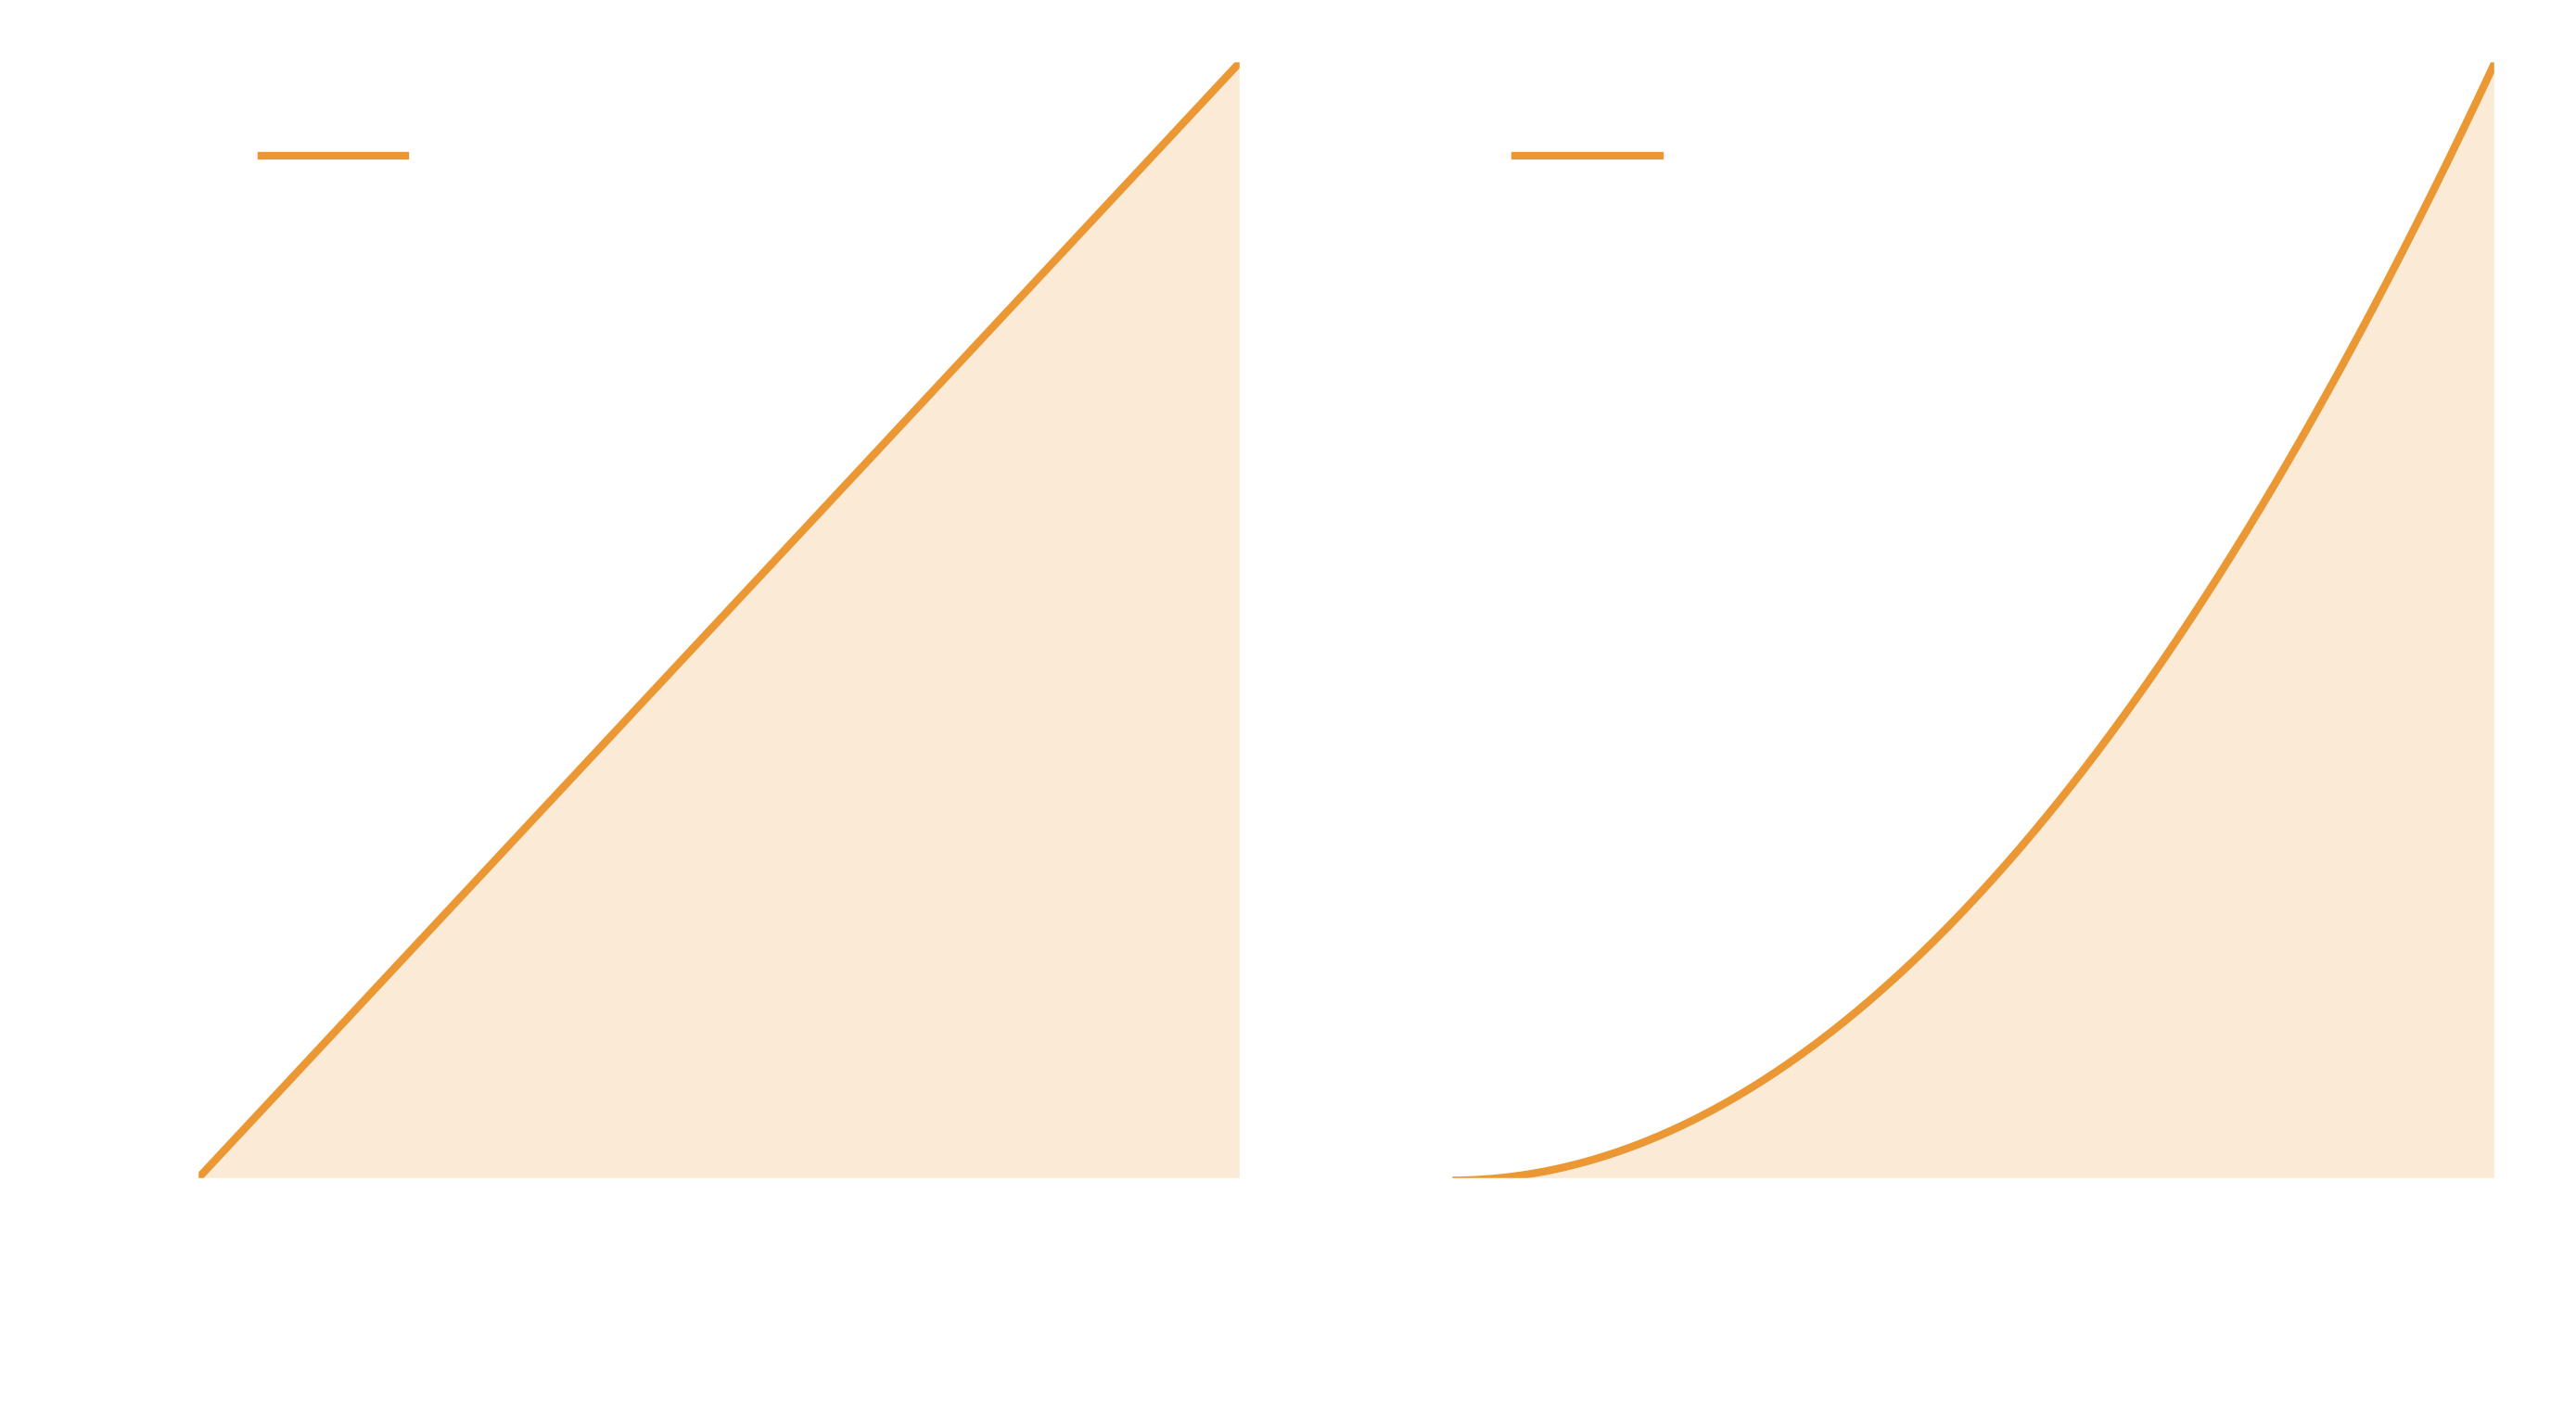

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def pdf(x):
    return 2 * x
def cdf(x):
    return x**2

xs = np.linspace(0, 1, 1000)
ps = pdf(xs)
cdfs = cdf(xs)

fig, axes = plt.subplots(ncols=2)
axes[0].plot(xs, ps, label="PDF") 
axes[0].fill_between(xs, ps, 0, alpha=0.2)
axes[1].plot(xs, cdfs, label="CDF") 
axes[1].fill_between(xs, cdfs, 0, alpha=0.2)
axes[0].set_xlabel("x"), axes[1].set_xlabel("x")
axes[0].legend(), axes[1].legend();

So in our case, the CDF looks pretty similar to the PDF, obviously this won't be the case if we picked something other than a simple polynomial, but you get the idea. The property that we are making use of is that the CDF will - by definition - go from 0 to 1 for any PDF. So for inversion sampling, we follow a simple procedure:

1. Pick a number (our CDF value) between 0 and 1
2. Figure out what $x$ value gives that CDF
3. Return that $x$ value as our sample.

That's it! 

The most common cause of confusion is "Why are we uniformly sampling the CDF?" Think about it like this - between CDF values 0.2 and 0.4, there is 20% of the probability area, right? And if you uniformly sample between 0 and 1, you get between 0.2 and 0.4 20% of the time.

So let's write this up for our function above, and then we'll generalise to *any* function and remove the math.


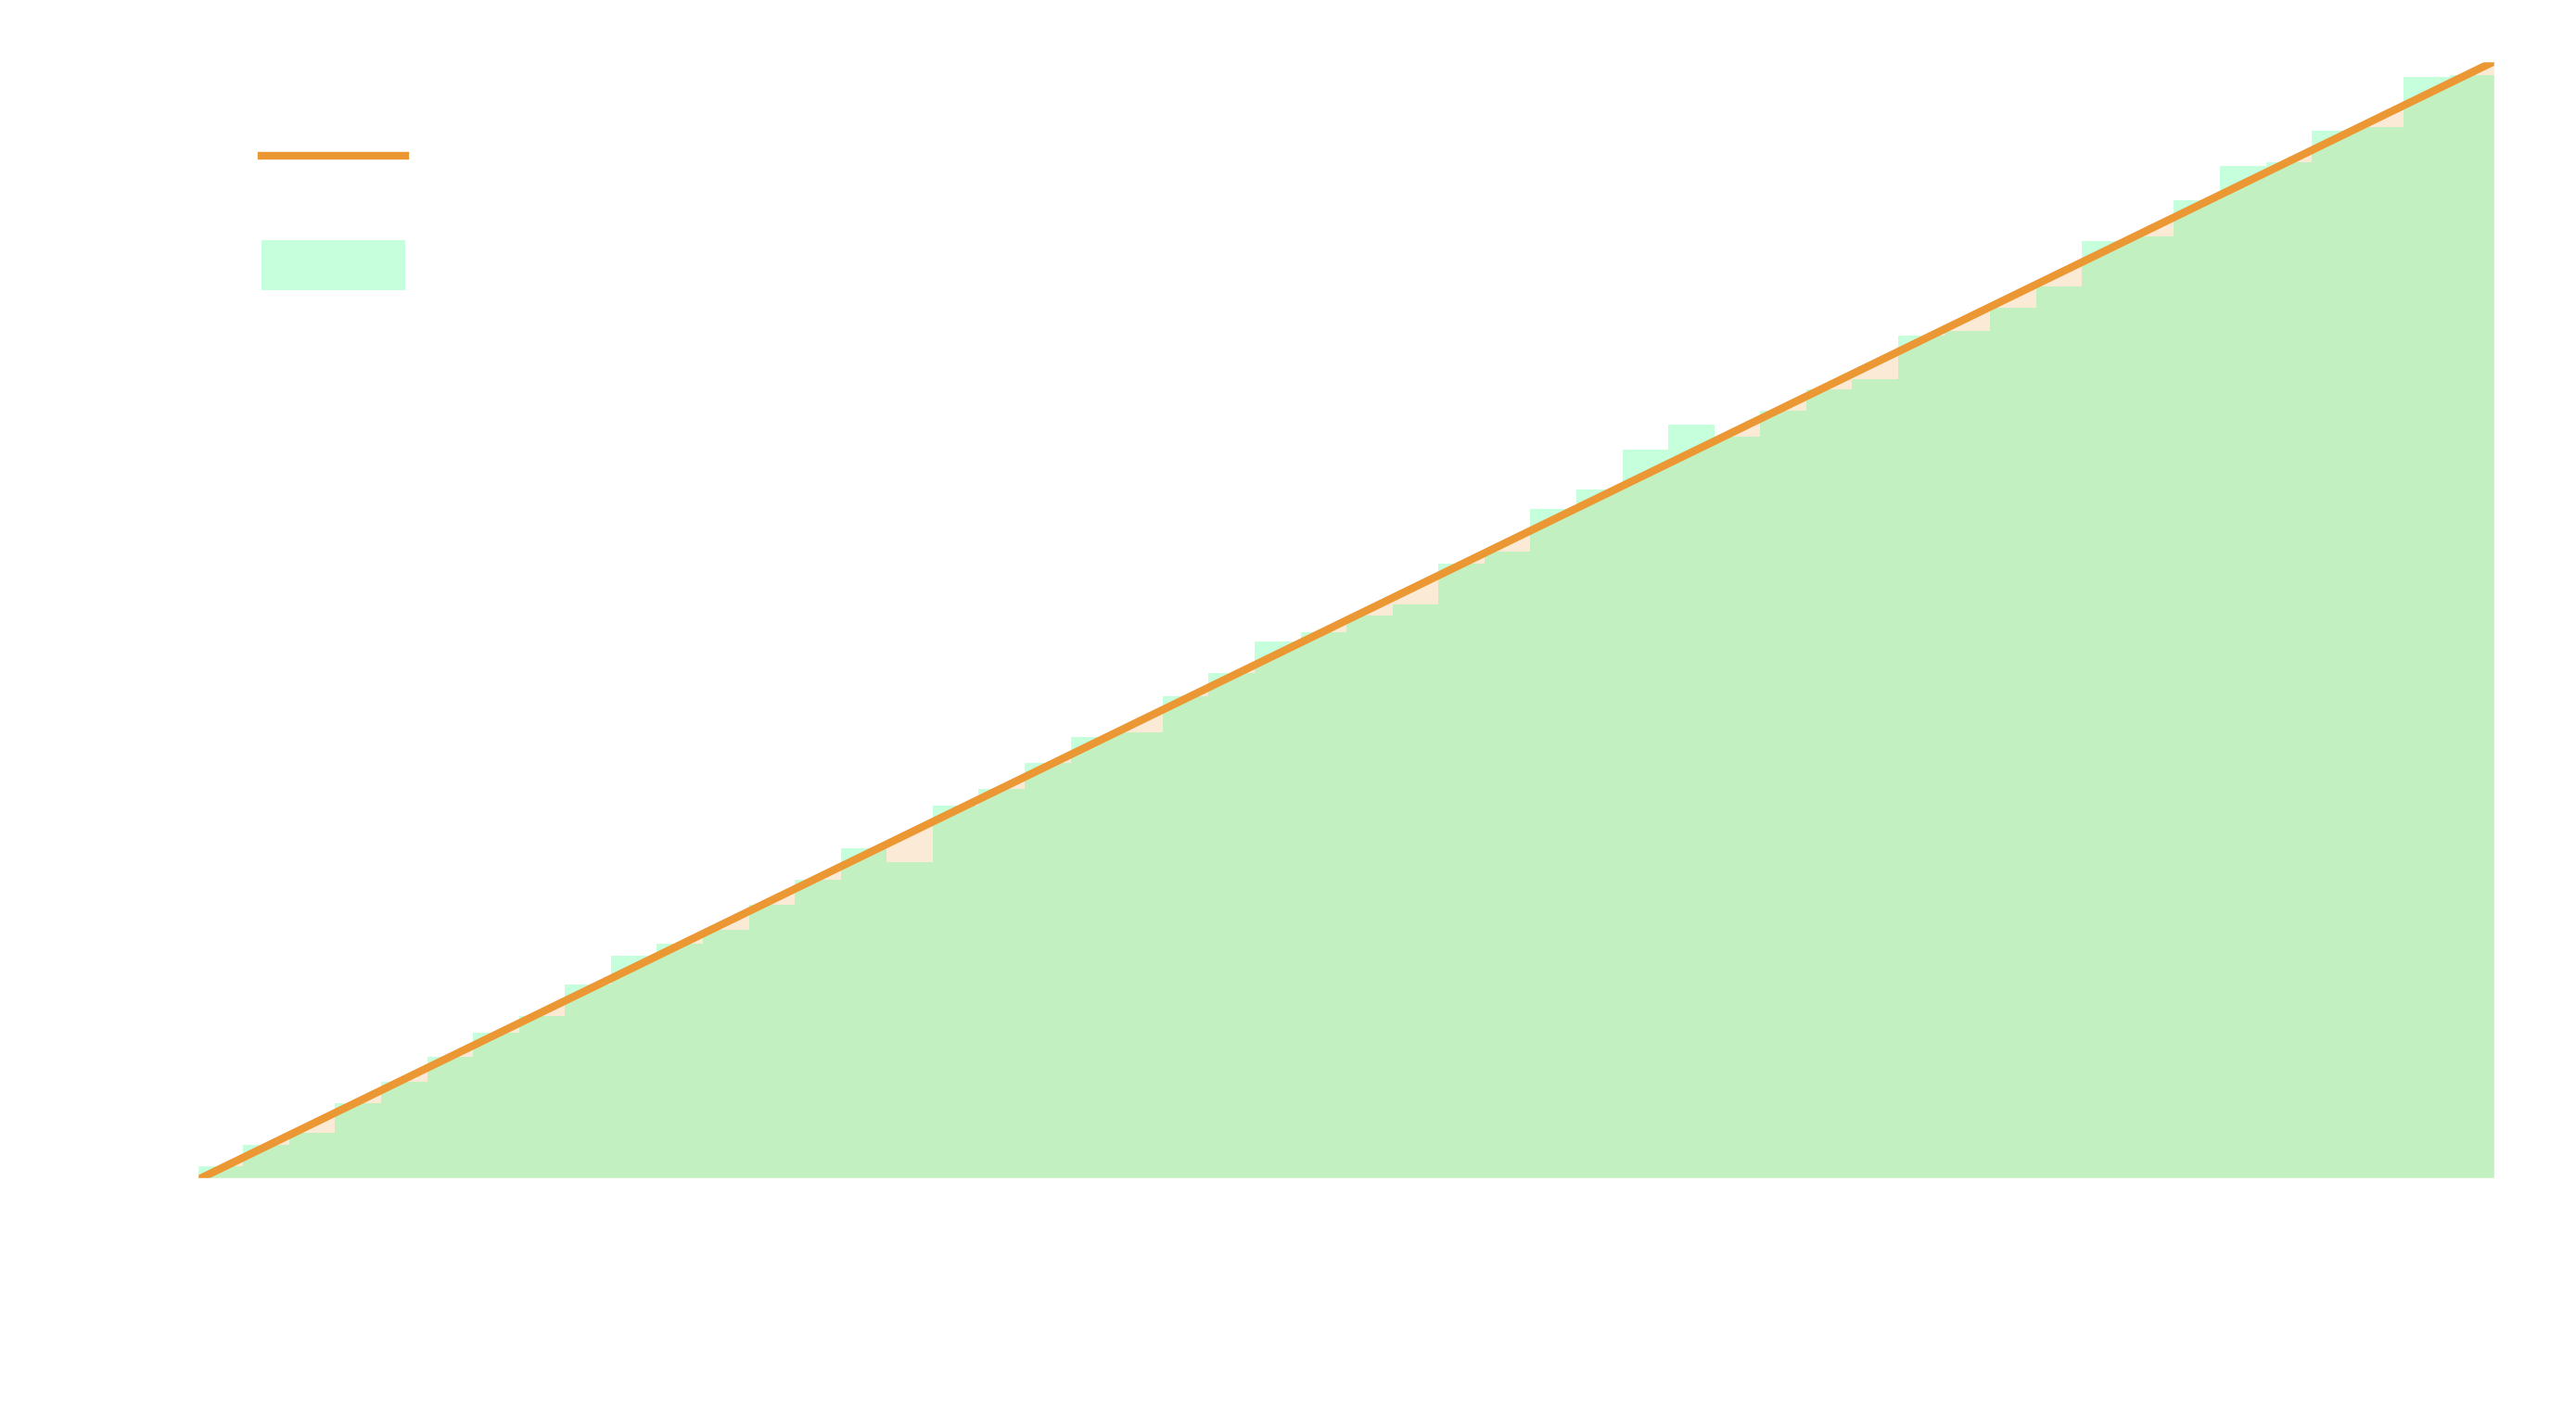

In [6]:
def inverse_cdf(cdf):
    return np.sqrt(cdf)  # cdf = x**2, so x = sqrt(cdf)

def sample(n=1):
    u = np.random.random(size=n)
    return inverse_cdf(u)

samples = sample(n=100000)

plt.plot(xs, ps, label="PDF") 
plt.fill_between(xs, ps, 0, alpha=0.2)
plt.hist(samples, density=True, alpha=0.3, label="Samples")
plt.legend(), plt.xlabel("x");

Great, so this is obviously working well, the sample distribution closely follows the input PDF. So lets generalise this to be any function. We can use simple numeric integration to remove the requirement for us to be able to analytically integrate and then invert the PDF.

In [7]:
plt.rcParams['axes.prop_cycle'] = (
    cycler(color=['#1f9bed', '#b66dde', '#F77F00', '#FCBF49', '#EAE2B7']) + 
    cycler(linestyle=['-', '--', ':', '-.', '-']))

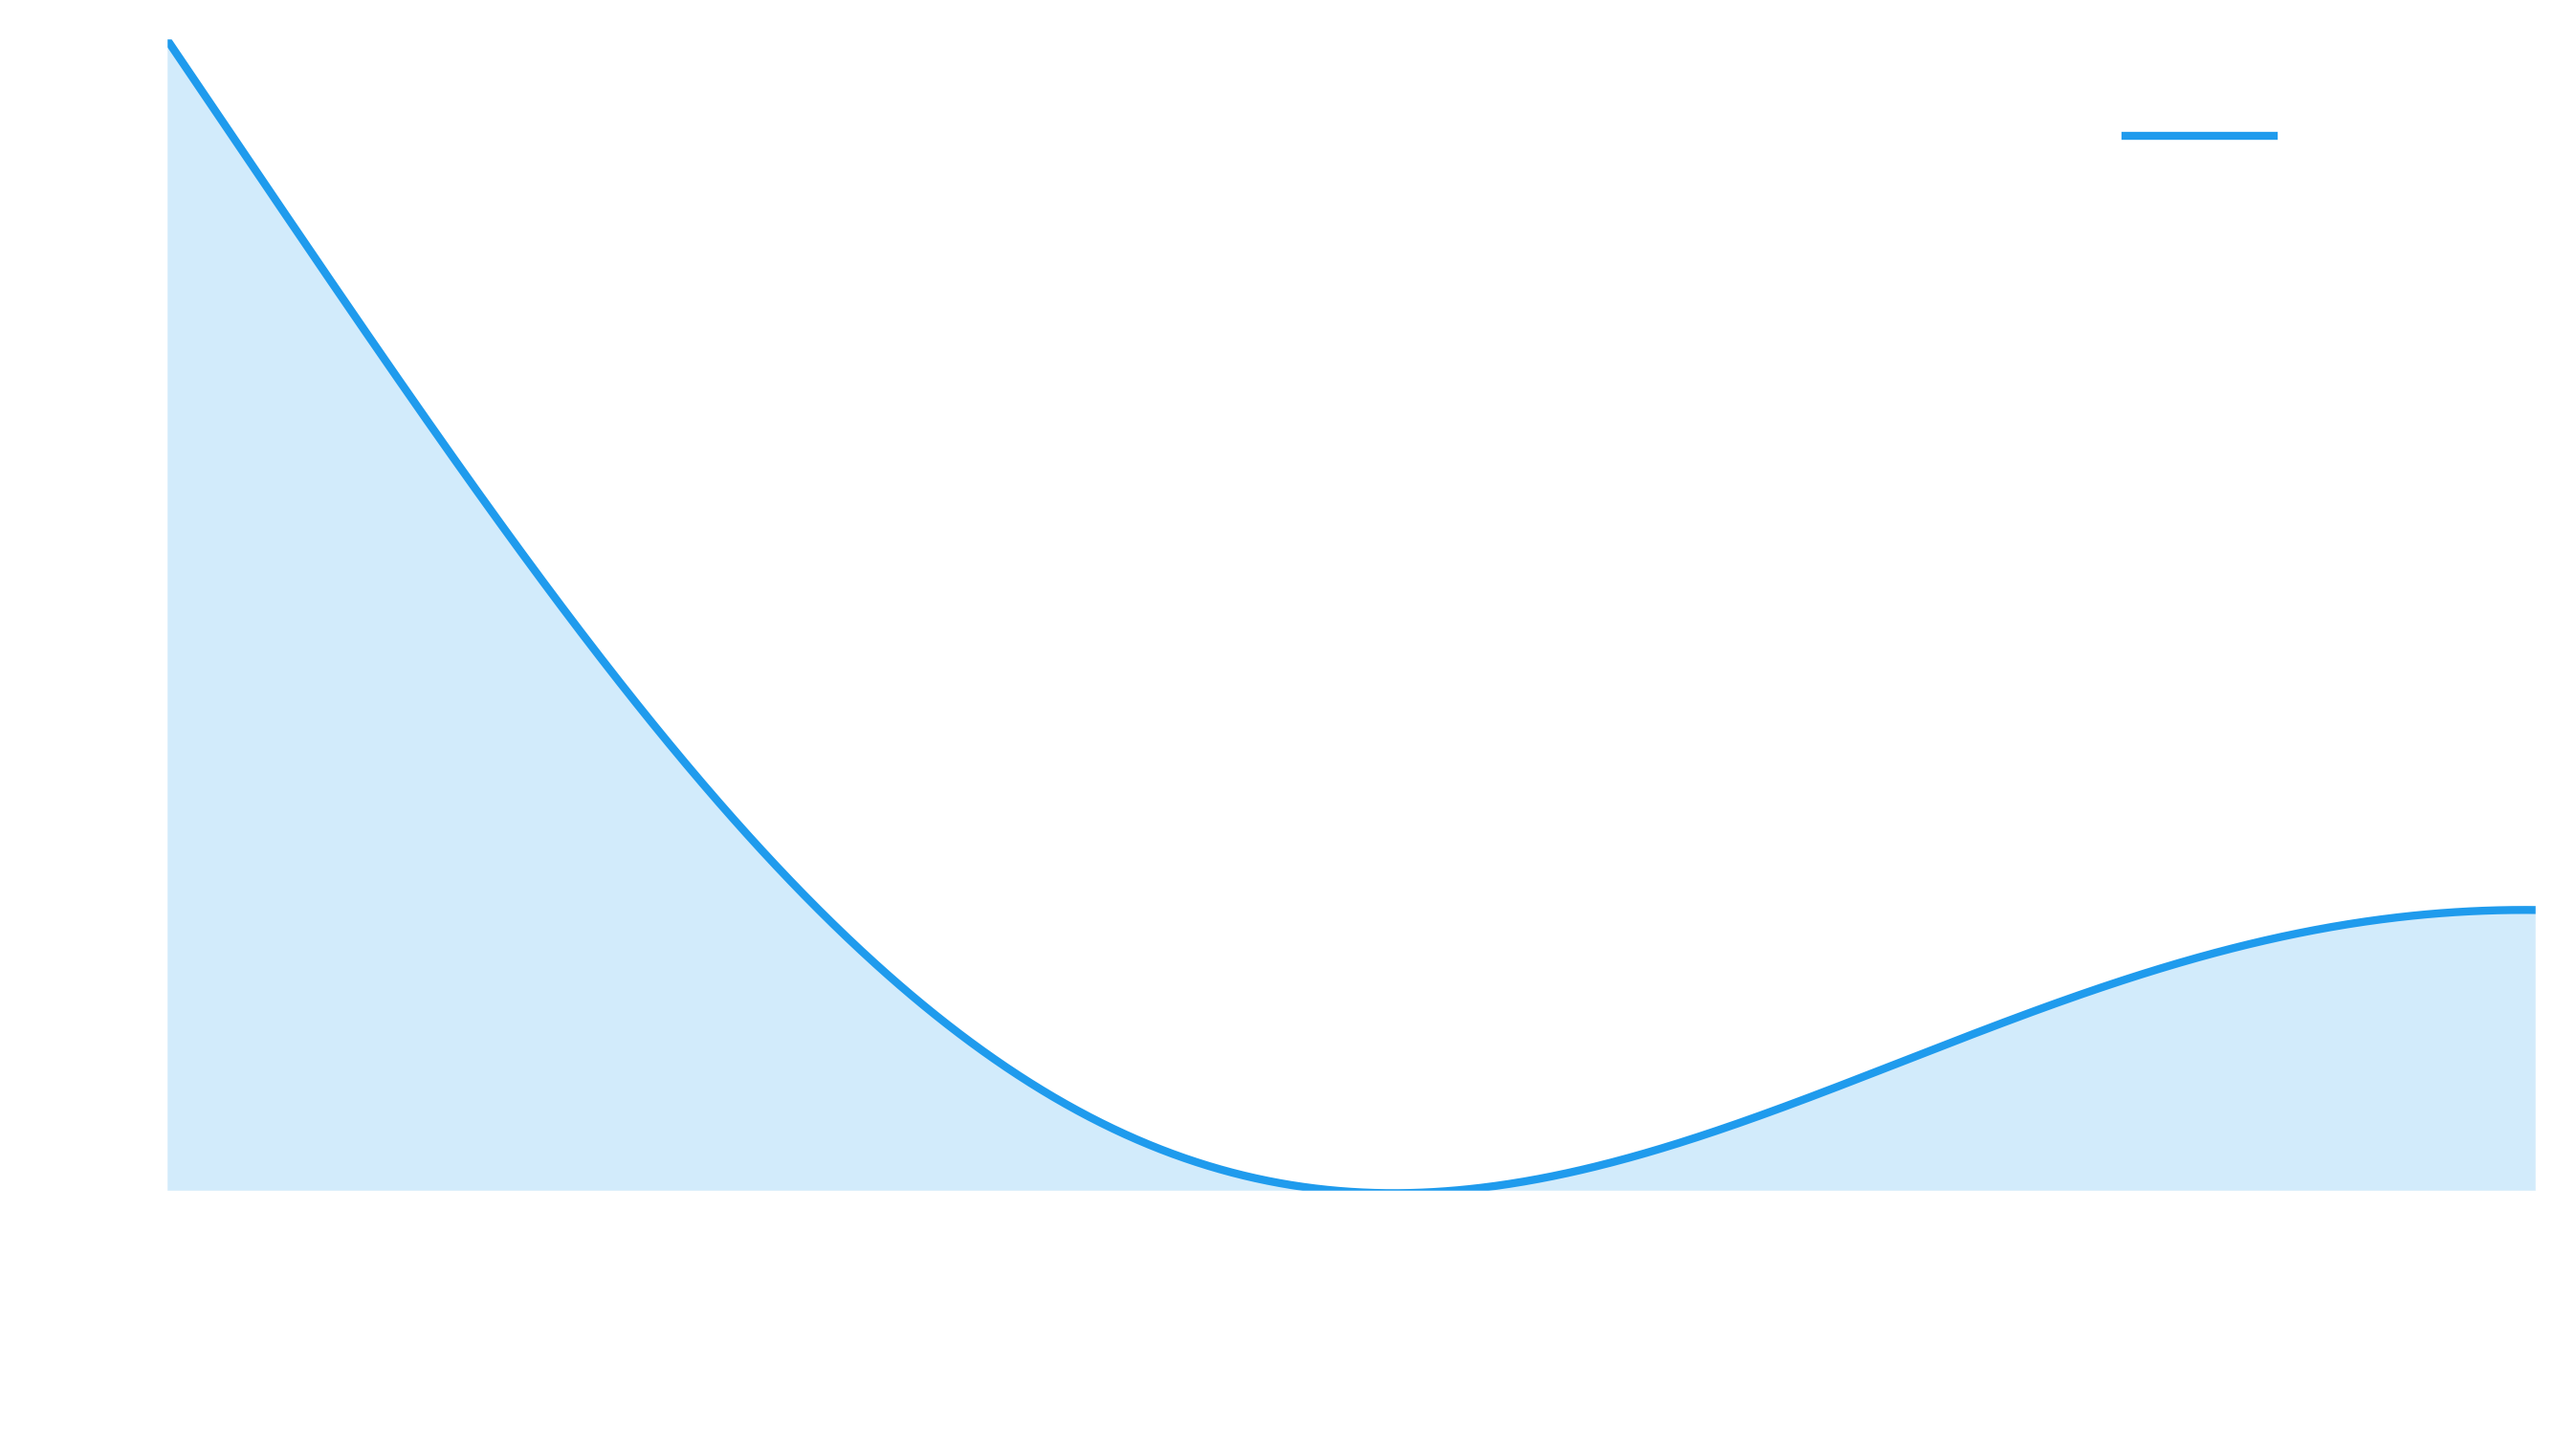

In [8]:
xs = np.linspace(0, 6.06948, 1000)
pdfs = ((1 + np.cos(xs)) / (1.5 * xs + 3))

plt.plot(xs, pdfs, label="PDF")
plt.fill_between(xs, pdfs, 0, alpha=0.2)
plt.xlabel("x"), plt.legend();

Now lets determine the CDF, invert it, and return an interpolator we can use to sample it:

In [9]:
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

def get_inverted_cdf(xs, pdfs):
    cdfs = cumtrapz(pdfs, x=xs) # Get the CDF using a very fast trapz rule
    cdfs = cdfs / cdfs.max()  # Ensure its normalised, to cater for unnormalised PDFs
    cdfs = np.insert(cdfs, 0, 0)  # Add the 0 area to start of the CDF array
    return interp1d(cdfs, xs, kind="linear")  # return interpolation from cdf -> x
    
def sample_fn(fn, n=1):
    return fn(np.random.random(size=n))

fn = get_inverted_cdf(xs, pdfs)
samples_2 = sample_fn(fn, n=100000)

Let's check it works by comparing the histogram of samples to the function:

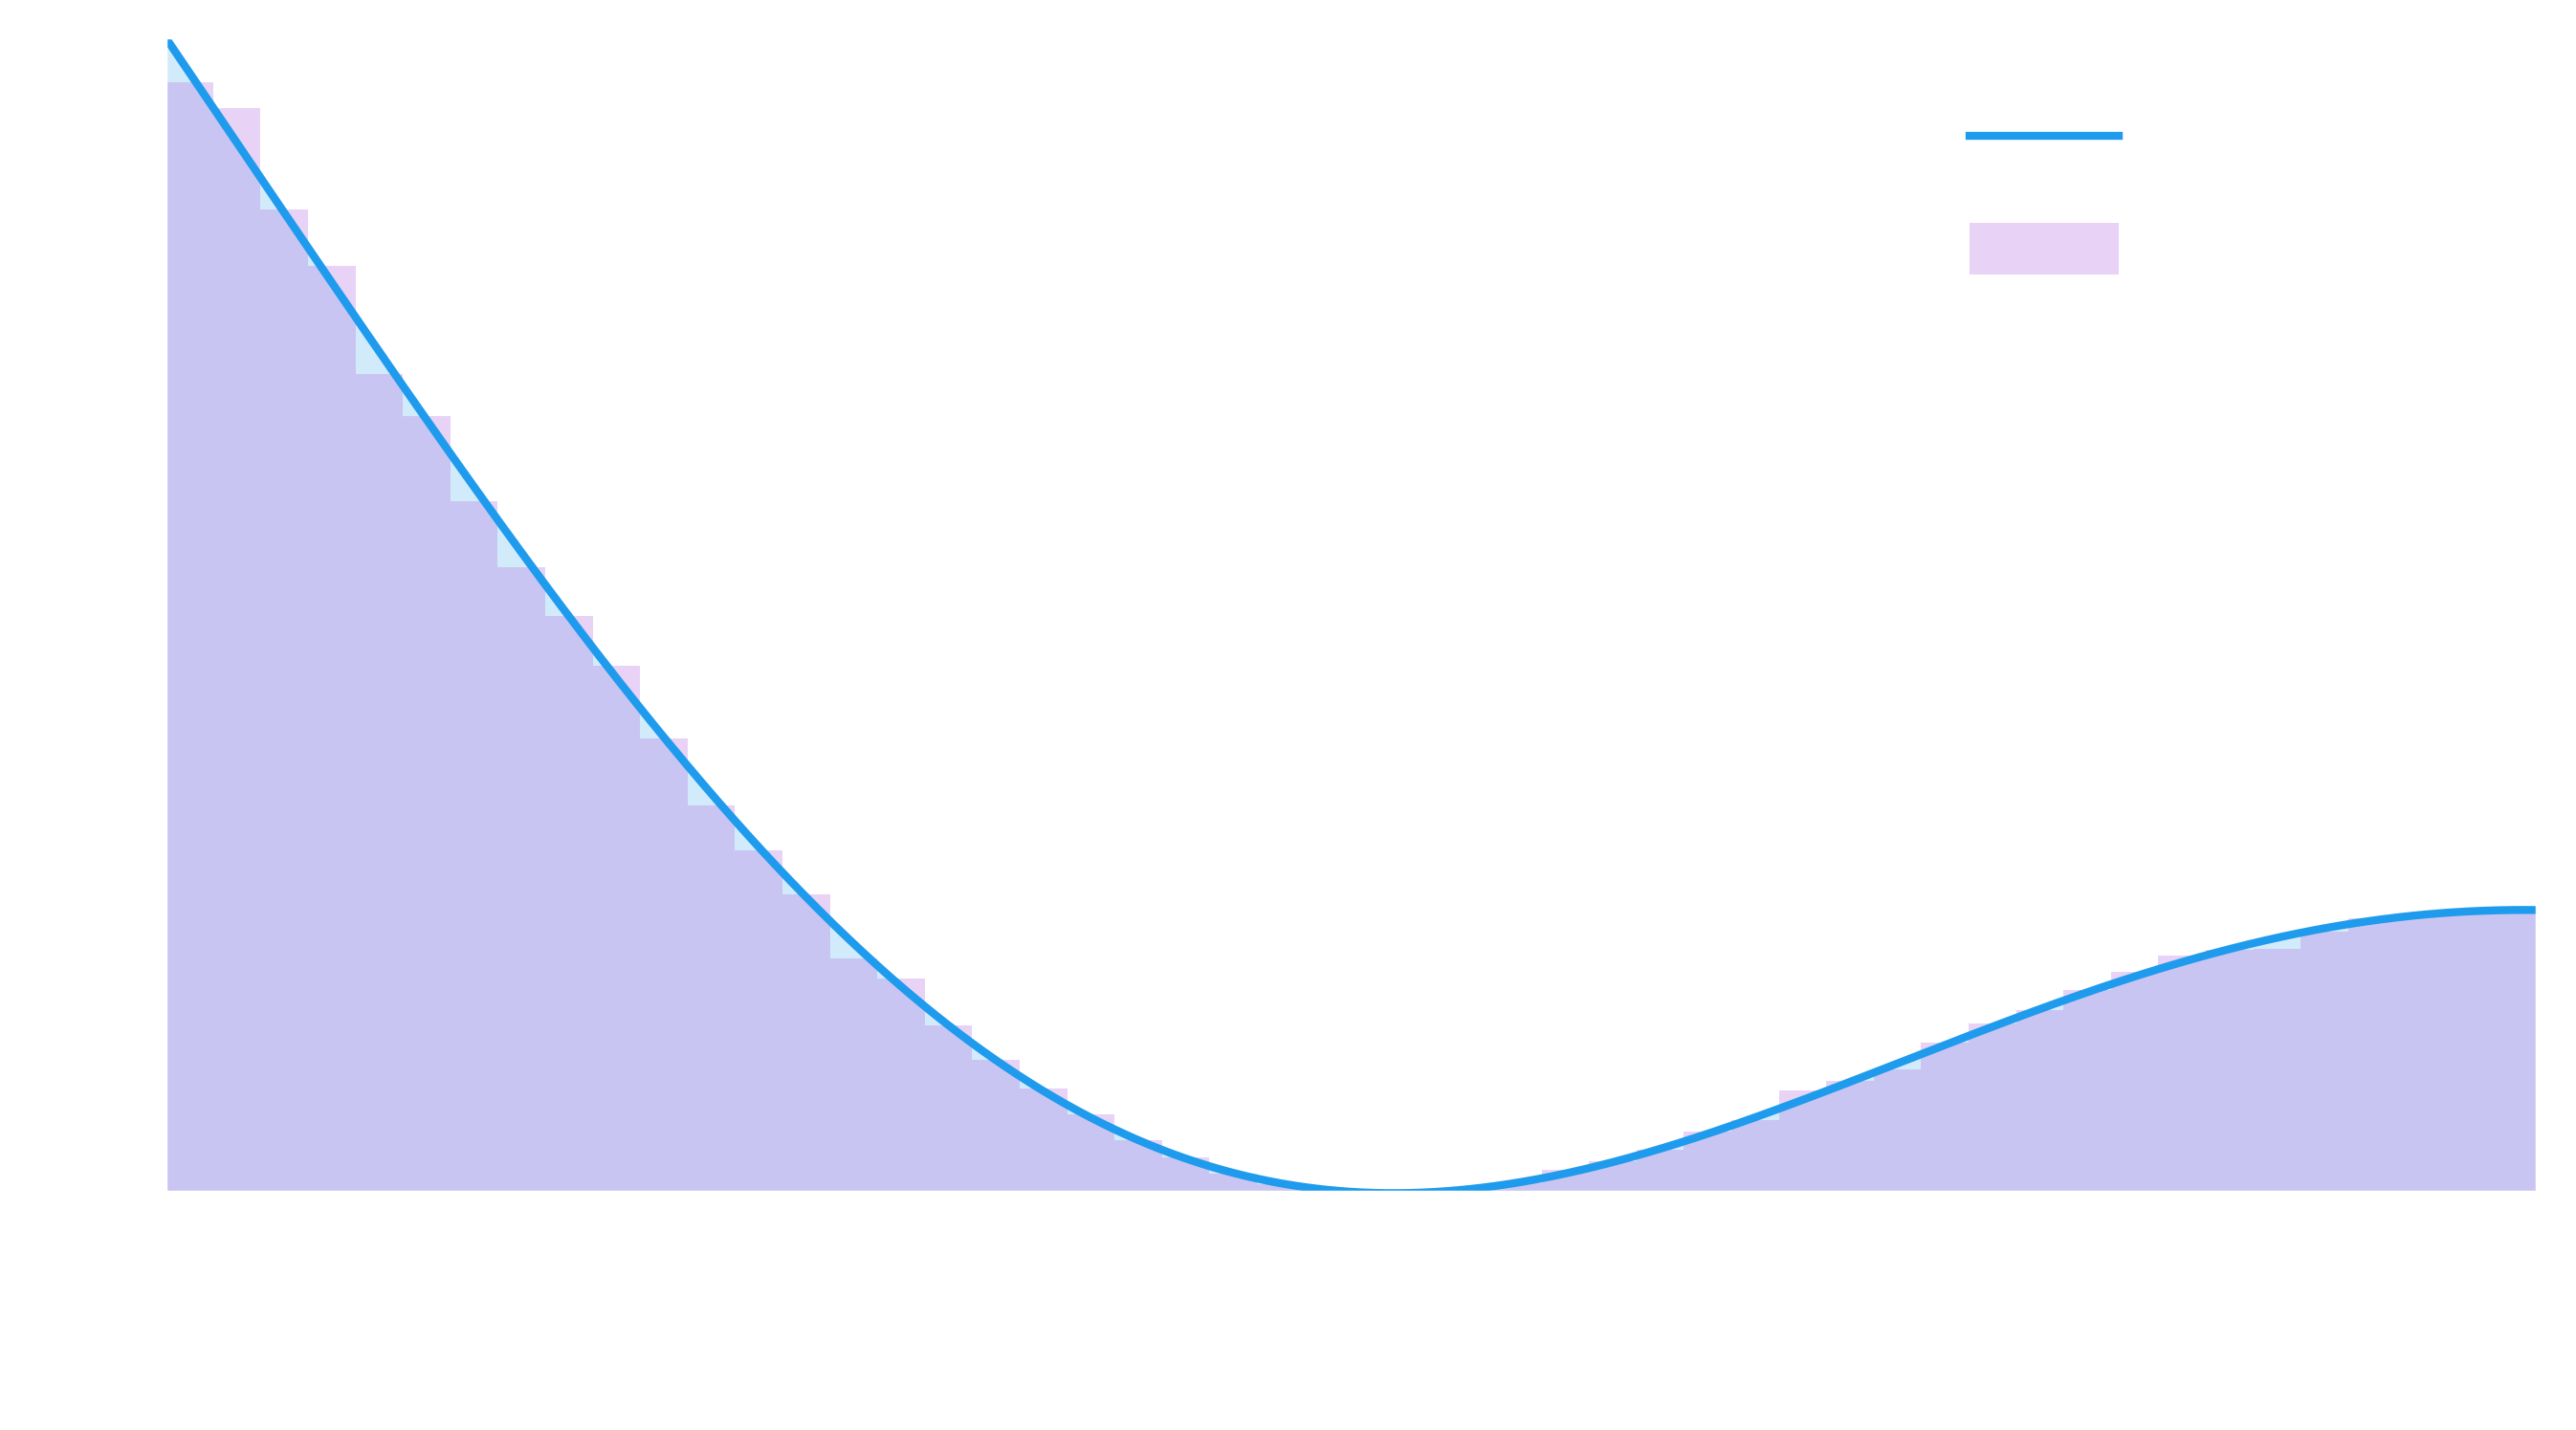

In [10]:
plt.plot(xs, pdfs, label="PDF") 
plt.fill_between(xs, pdfs, 0, alpha=0.2)
plt.hist(samples_2, density=True, alpha=0.3, label="Samples")
plt.legend(), plt.xlabel("x");

Beautiful. Now to try and tie it all together, here is one final, more complicated plot, showing the sampling of the CDF (on the top y axis), to figuring out what $x$ value it corresponds to, to where those samples lie in the PDF on the bottom.

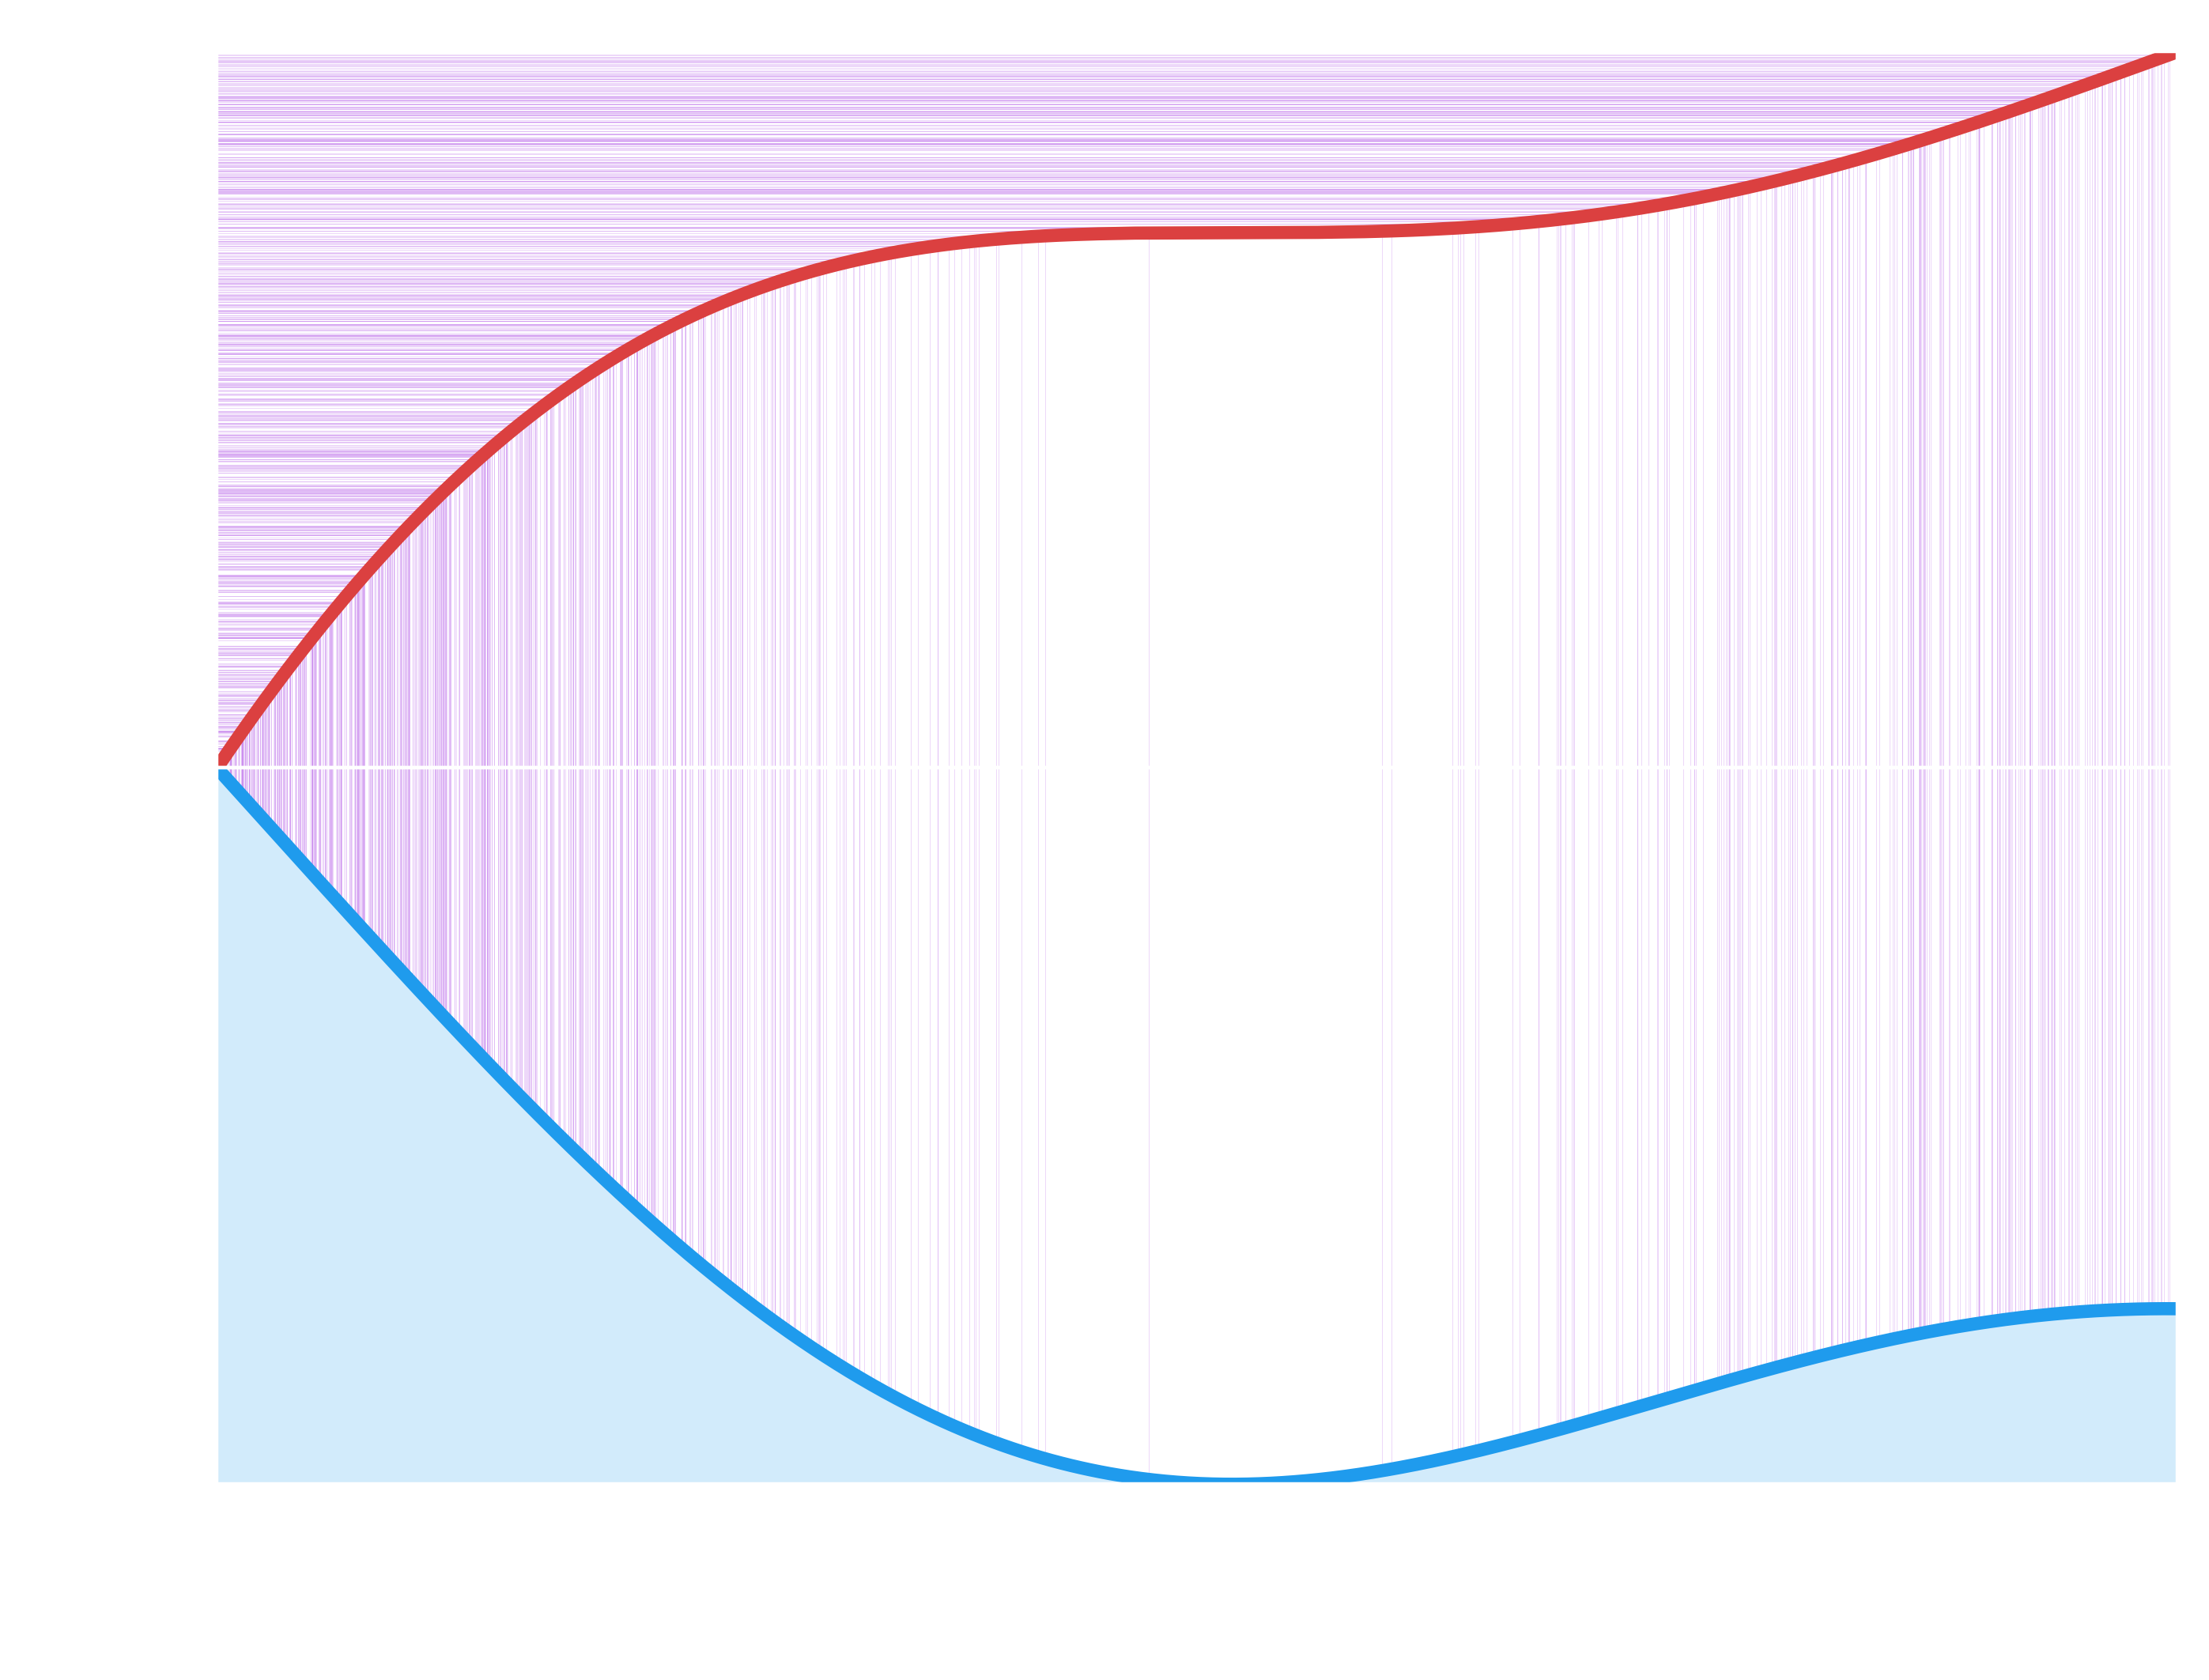

In [12]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 6), sharex=True, gridspec_kw={"hspace": 0})

c = np.linspace(0, 1, 1000)
q = fn(c)

us = np.random.random(size=1000)
vs = fn(us)
yv = ((1 + np.cos(vs)) / (1.5 * vs + 3))

lines = {"color": "#c075eb", "lw": 0.1, "alpha": 0.5}
for u, v, y in zip(us, vs, yv):
    axes[0].axhline(u, xmin=0, xmax=v/xs.max(), **lines)
    axes[0].axvline(v, ymin=0, ymax=u, **lines)
    axes[1].axvline(v, ymin=y/pdfs.max(), **lines)

axes[0].plot(q, c, label="CDF", color="#db4040", lw=3)
axes[1].plot(xs, pdfs, label="PDF", lw=3) 
axes[1].fill_between(xs, pdfs, 0, alpha=0.2)
axes[1].set_xlabel("x")  ###REMOVE
axes[1].set_ylabel("PDF")  ###REMOVE
axes[0].set_ylabel("CDF")  ###REMOVE
axes[0].set_xlim(0, xs.max()), axes[1].set_xlim(0, xs.max());  ###REMOVE

!!!main

So you can see - hopefully fairly clearly - how our uniform sampling on the CDF, after being traced horizontally to the CDF and then vertically down to the $x$ value, gives us samples which are distributed according to the underlying PDF.